Status: Optimal
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2      UK301  Landing         12              6         -6         3
3     VTI404  Takeoff         15             10         -5         2
5      AI106  Landing         20             12         -8         1
4      G8205  Landing         18             16         -2         2
7      UK310  Landing         25             19         -6         2
6      6E209  Takeoff         22             22          0         3
9      AI112  Landing         30             24         -6         1
8      G8210  Takeoff         28             28          0         2
11     UK318  Landing         35             30         -5         2
10     6E215  Takeoff         33             33          0         3
12     G8218  Takeoff         38             35         -3         2
14     6E223  Take

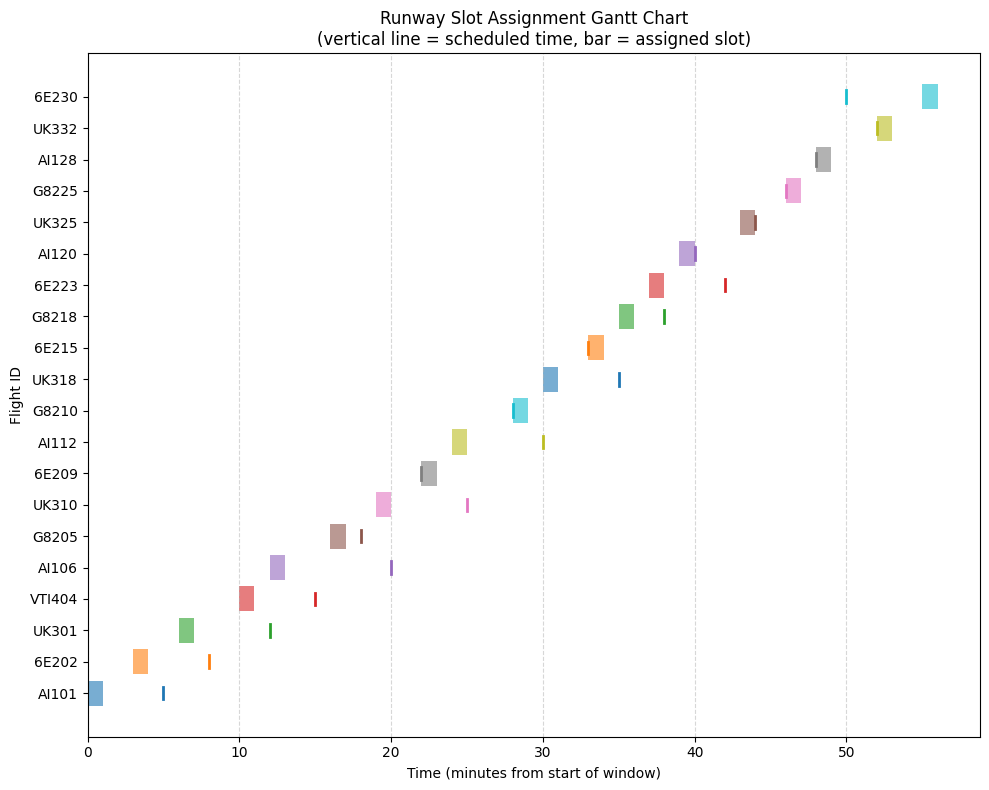

In [1]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 60))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Status: Infeasible
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              3         -2         1
1      6E202  Takeoff          8              3         -5         2
2      UK301  Landing         12              7         -5         3
3     VTI404  Takeoff         15             14         -1         2
5      AI106  Landing         20             15         -5         1
4      G8205  Landing         18             16         -2         2
6      6E209  Takeoff         22             22          0         3
8      G8210  Takeoff         28             24         -4         2
7      UK310  Landing         25             25          0         2
9      AI112  Landing         30             25         -5         1
11     UK318  Landing         35             31         -4         2
12     G8218  Takeoff         38             31         -7         2
10     6E215  Takeoff         33             32         -1         3
15     UK325  L

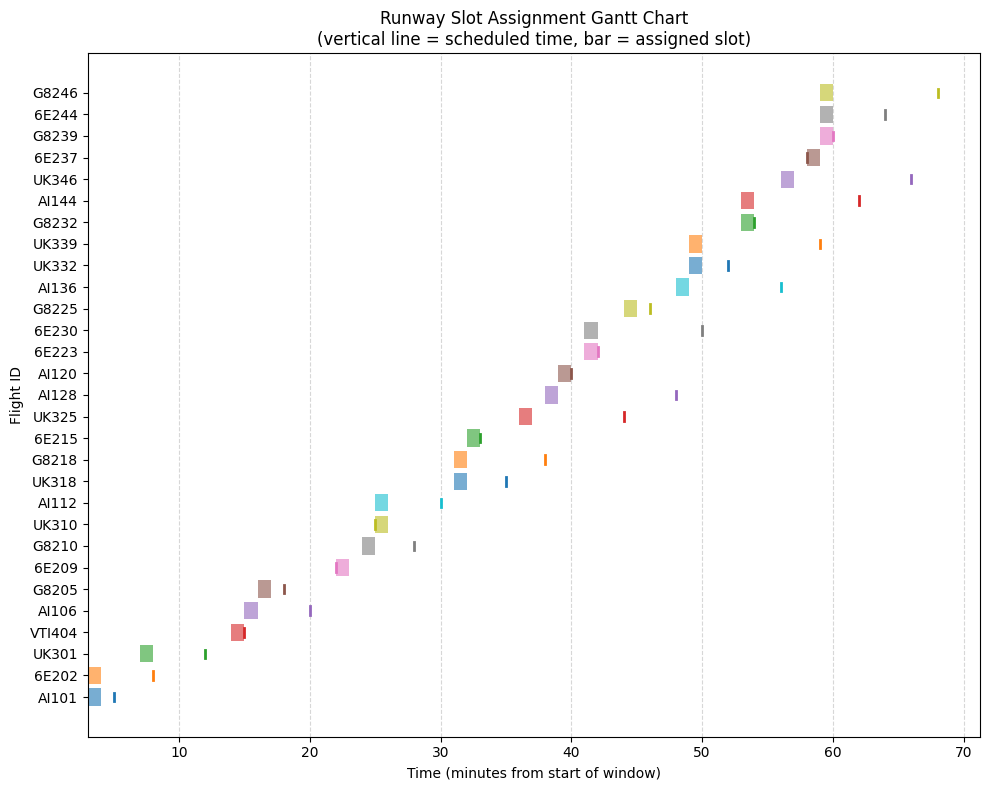

In [3]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_4.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 120))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Status: Infeasible
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2     VTI404  Takeoff         15             12         -3         2
3      6E209  Takeoff         22             15         -7         3
4      UK310  Landing         25             19         -6         2
5      G8210  Takeoff         28             20         -8         2
6      AI112  Landing         30             23         -7         1
7      6E215  Takeoff         33             25         -8         3
8      UK318  Landing         35             27         -8         2
9      G8218  Takeoff         38             30         -8         2
10     AI120  Landing         40             31         -9         1
11     6E223  Takeoff         42             32        -10         3
12     UK325  Landing         44             35         -9         2
13     G8225  T

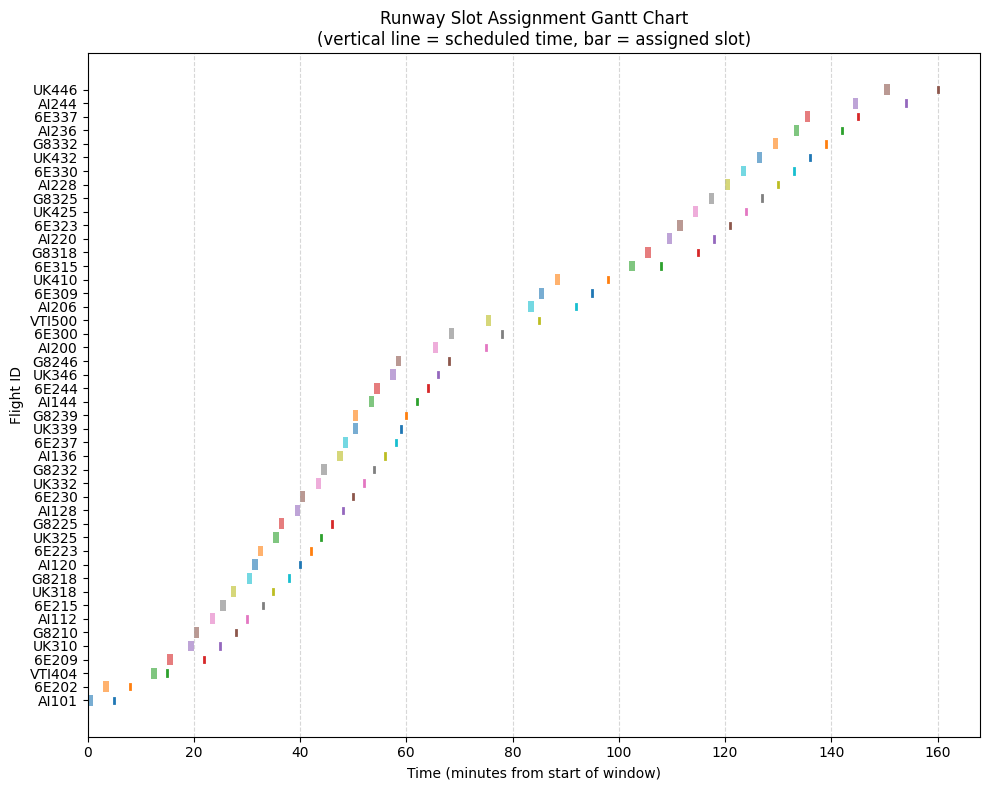

In [8]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_4.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 300))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()